In [1]:
%load_ext lab_black
import pandas as pd
import numpy as np
import sklearn.linear_model as lm
import sklearn.ensemble as en
import sklearn.tree as tree
import matplotlib.pyplot as plt
from src.linear_coef_matching import LCM
from src.linear_coef_matching_mf import LCM_MF
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score
import warnings
import seaborn as sns

warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv("/Users/harshparikh/Documents/max_df_coarsen.csv", index_col=0)

data.head()

,Gender,Age,Marrital,iGCS-Total,iGCS = T?,Worst GCS in 1st 24h,Worst GCS intub,APACHE II 1st 24h,SBP highest (1st 24h),SBP lowest (1st 24h),...,phenobarbital_50,propofol_Hill,propofol_50,valproate_Hill,valproate_50,Y,T,Race_Asian,Race_Black or African American,Race_White or Caucasian
sid3,1,45.91,1,8,0,8,0,15,148,139,...,31.258455,22.956908,28.551287,9.440983,50.069078,1,"(0.88, 1)",0,0,1
sid4,1,53.99,1,4,0,3,1,29,170,50,...,31.258455,23.802689,34.336808,9.440983,50.069078,1,"(0.88, 1)",0,0,1
sid5,1,23.08,0,6,1,3,1,22,126,96,...,31.258455,23.346894,33.508543,9.440983,50.069078,0,"(0.12, 1)",0,0,1
sid7,1,32.11,1,3,1,3,1,16,133,112,...,31.258455,26.847907,29.452211,9.440983,50.069078,1,"(0.88, 1)",0,0,0
sid8,0,67.24,0,12,0,11,0,14,200,147,...,31.258455,26.111897,34.910724,9.440983,50.069078,1,"(0.88, 1)",0,0,0


In [141]:
lcm = LCM_MF(
    outcome="Y", treatment="T", data=data, n_splits=3, n_repeats=10, random_state=0
)

lcm.fit(model="linear", separate_treatments=True)

{'(0.12, 0)': 0.8928571428571429, '(0.12, 1)': 0.7702702702702703, '(0.38, 0)': 0.8666666666666667, '(0.38, 1)': 0.8620689655172413, '(0.62, 0)': 1.0, '(0.62, 1)': 0.84, '(0.88, 0)': 0.8333333333333334, '(0.88, 1)': 0.908256880733945}
{'(0.12, 0)': 0.8928571428571429, '(0.12, 1)': 0.9324324324324325, '(0.38, 0)': 0.8, '(0.38, 1)': 1.0, '(0.62, 0)': 1.0, '(0.62, 1)': 0.84, '(0.88, 0)': 0.926829268292683, '(0.88, 1)': 0.8990825688073395}
{'(0.12, 0)': 0.8275862068965517, '(0.12, 1)': 0.8513513513513513, '(0.38, 0)': 1.0, '(0.38, 1)': 0.6785714285714286, '(0.62, 0)': 0.9090909090909091, '(0.62, 1)': 0.92, '(0.88, 0)': 0.8095238095238095, '(0.88, 1)': 0.8796296296296297}
{'(0.12, 0)': 0.9642857142857143, '(0.12, 1)': 0.8783783783783784, '(0.38, 0)': 0.6666666666666666, '(0.38, 1)': 0.7931034482758621, '(0.62, 0)': 1.0, '(0.62, 1)': 0.96, '(0.88, 0)': 0.9523809523809523, '(0.88, 1)': 0.8899082568807339}
{'(0.12, 0)': 0.9285714285714286, '(0.12, 1)': 0.8918918918918919, '(0.38, 0)': 0.866666

In [142]:
M_df = pd.concat(
    [pd.DataFrame(lcm.M_list[i], index=lcm.covariates) for i in range(len(lcm.M_list))],
    axis=1,
)
M_df.mean(axis=1).sort_values(ascending=False).to_latex("stretches_iic.tex")

In [166]:
M_df.mean(axis=1).sort_values(ascending=False).index[:5]

Index(['APACHE II 1st 24h', 'Age', 'EEG day1 GCS', 'EEG day1 sysBP',
       'HR lowest (1st 24h)'],
      dtype='object')

In [144]:
lcm.MG(k=1)
lcm.CATE(cate_methods=["mean"], diameter_prune=-1)

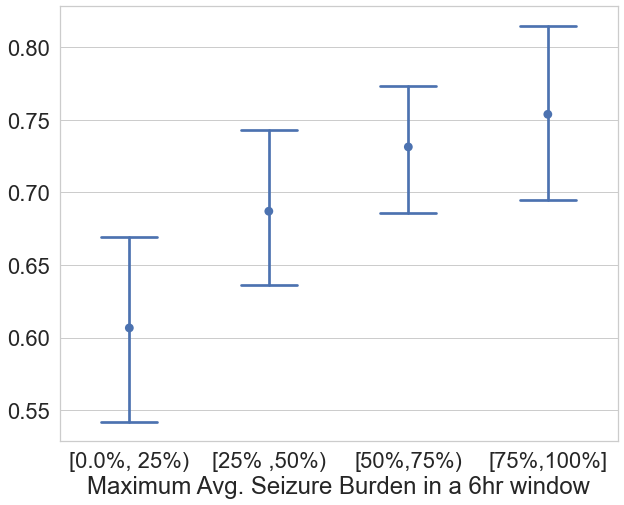

In [217]:
sns.set(font_scale=2)
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(10, 8))
sns.pointplot(
    data=lcm.cate_df[
        ["Y(0.12, 0)_mean", "Y(0.38, 0)_mean", "Y(0.62, 0)_mean", "Y(0.88, 0)_mean"]
    ]
    .rename(
        columns={
            "Y(0.12, 0)_mean": "[0.0%, 25%)",
            "Y(0.38, 0)_mean": "[25% ,50%)",
            "Y(0.62, 0)_mean": "[50%,75%)",
            "Y(0.88, 0)_mean": "[75%,100%]",
        }
    )
    .T.reset_index()
    .groupby(by="index")
    .mean()
    .T,
    join=False,
    capsize=0.4,
    errorbar="se",
)
# ax.set_xticks(ticks=[0,1,2,3], labels=['[0.0,0.25)','[0.25,0.5)','[0.5,0.75)','[0.75,1.0]'])
plt.xlabel("Maximum Avg. Seizure Burden in a 6hr window")
plt.savefig("ATE_IIC.png")

In [146]:
lcm.MG(k=1)

In [147]:
cates = (
    lcm.cate_df[
        ["Y(0.12, 0)_mean", "Y(0.38, 0)_mean", "Y(0.62, 0)_mean", "Y(0.88, 0)_mean"]
    ]
    .T.reset_index()
    .groupby("index")
    .mean()
    .T
)

In [148]:
cates["patient_id"] = data.index

In [149]:
l_mg = lcm.get_MGs()

In [181]:
a = []
for d_itr in l_mg:
    for key in d_itr.keys():
        mg_key = d_itr[key]
        if 314 in mg_key.index:
            a.append(mg_key.loc[314][0])

In [182]:
MG_sid603 = data.loc[list(cates.loc[set(a)]["patient_id"])]

In [183]:
malts_mg = set(
    ["sid152", "sid260", "sid489", "sid917", "sid1021", "sid1766", "sid1771"]
)
lcm_mg = set(MG_sid603.index)

In [184]:
malts_mg.intersection(lcm_mg)

{'sid1021', 'sid152', 'sid1766', 'sid260'}

In [193]:
MG_sid603.loc[
    MG_sid603.apply(
        lambda x: ((x["Age"] > 45) and (x["Age"] < 55) and ("1)" not in x["T"])),
        axis=1,
    )
][M_df.mean(axis=1).sort_values(ascending=False).index[:7]].round(0).astype(
    int
).to_latex(
    "sid603_mg.tex"
)